# Taha Samavati - 98722134 - Pattern Recognition
## First project Part 2 - Bert Embeddings
### Table of contents:
    2.Bert embeddings - sentence
      2.0 Preprocessing
      2.1. Gaussian Naive Bayes
        2.1.1. Evaluation : Confusion matrix + ROC
      2.2.SVM
        2.2.1 Evaluation : Confusion matrix + ROC
      2.3.Decision Tree
        2.3.1 Evaluation : Confusion matrix + ROC
      2.4.Random Forest
        2.4.1 Evaluation : Confusion matrix + ROC
      2.5. Performance Comparison of classifiers - Bert-Sentences





In [0]:
import numpy as np
import nltk
import re
import pandas as pd
import os
import natsort
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

# 2.Bert Embeddings

## 2.0 Preprocessing
* Split each comment by '.' and create array containing sentences for each comment

In [0]:
df_train_bert = df_train.copy()
for i in range (df_train.shape[0]):
    arst = df_train['comment'][i].split('.')
    # remove last element becuase it's empty
    arst.pop()
    df_train_bert ['comment'][i] = arst

In [0]:
df_test_bert = df_test.copy()
for i in range (df_test.shape[0]):
    arst = df_test['comment'][i].split('.')
    arst.pop()
    df_test_bert ['comment'][i] = arst

In [0]:
# Load preprocessed data_frames
df_train = pd.read_csv('/content/gdrive/My Drive/Pattern_Recognition/cleaned_train_df_bert.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/Pattern_Recognition/cleaned_test_df_bert.csv')

* **Install sentence-transformers and download pretrained model**

In [0]:
!python3 -m pip install -U sentence-transformers

In [0]:
from sentence_transformers import SentenceTransformer
from ast import literal_eval
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

100%|██████████| 405M/405M [00:24<00:00, 16.8MB/s]


* Create X_train data by transforming comments into bert embeddings

In [ ]:
X_train = np.zeros((df_train.shape[0],768))
for i in range(df_train.shape[0]):
  if i%1000 == 0:
    print("Processed "+str(i)+" train Comments...")
  sentence_embeddings = model.encode(literal_eval(df_train['comment'][i]))
  mean = np.mean(sentence_embeddings,axis = 0)
  X_train[i] = mean
np.save('/content/gdrive/My Drive/Pattern_Recognition/X_train_bert.npy', X_train)

* Create X_test data by transforming comments into bert embeddings

In [ ]:
X_test = np.zeros((df_test.shape[0],768))
for i in range(df_test.shape[0]):
  if i%1000 == 0:
    print("Processed "+str(i)+" test Comments...")
  sentence_embeddings = model.encode(literal_eval(df_test['comment'][i]))
  mean = np.mean(sentence_embeddings,axis = 0)
  X_test[i] = mean
np.save('/content/gdrive/My Drive/Pattern_Recognition/X_test_bert.npy', X_test)

In [0]:
y_train = np.load('/content/gdrive/My Drive/Pattern_Recognition/y_train.npy')
y_test = np.load('/content/gdrive/My Drive/Pattern_Recognition/y_test.npy')

In [0]:
X_train = np.load('/content/gdrive/My Drive/Pattern_Recognition/X_train_bert.npy')
X_test = np.load('/content/gdrive/My Drive/Pattern_Recognition/X_test_bert.npy')

In [0]:
# remove nan data produced by bert (there are very few of them)
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

## 2.1 Gaussian Naive Bayes
* In this part the input features are continous, so for simplicity we assume that features have normal distribution and use Gaussian naive bayes

In [0]:
# Create and fit Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb_model = gnb.fit(X_train,y_train)

### 2.1.1 EVALUATION

In [0]:
# Predict and print metrics
y_pred = np.zeros((X_test.shape[0]),dtype=np.int8)
for i in range(X_test.shape[0]):
    y_pred[i] = gnb.predict([X_test[i]])

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
precisions=[]
precisions.append(precision)

Presicion = 83.18706945094542 % Recall = 83.08 % f1 = 83.06634198879448 %


In [0]:
def plot_confusion_matrix(y_true,y_predicted, classes, normalize=False, title=None, cmap = plt.cm.Blues):
    if not title:
        if normalize:
            title = "Normalized Confusion matrix"
        else:
            title = "Confusion matrix, Without normalization"
    cm = confusion_matrix(y_true, y_predicted)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel="predicted label")
    plt.setp(ax.get_xticklabels(), rotation=45,ha='right', rotation_mode='anchor')
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

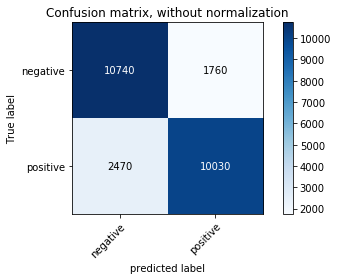

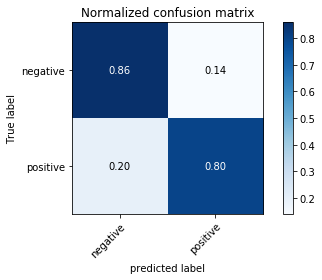

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=['negative','positive'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

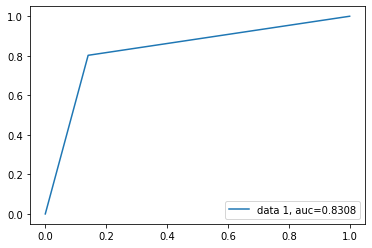

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

## 2.2. SVM Classifier

In [0]:
svmc = LinearSVC(C=0.09)
svmc.fit(X_train,y_train)

LinearSVC(C=0.09, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### 2.2.1. Evaluation

In [0]:
# Predict and print metrics
y_pred_svm = np.zeros((X_test.shape[0]),dtype=np.int8)
for i in range(X_test.shape[0]):
    y_pred_svm[i] = svmc.predict([X_test[i]])
#y_pred = gnb.predict(X_test)
precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
precisions.append(precision)

Presicion = 88.98003018613538 % Recall = 88.98 % f1 = 88.97999786652758 %


### Confusion matrix

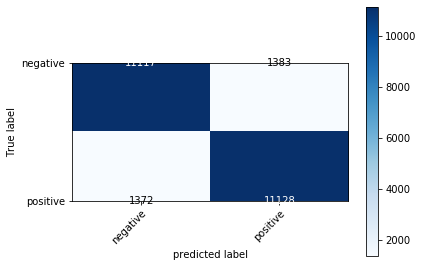

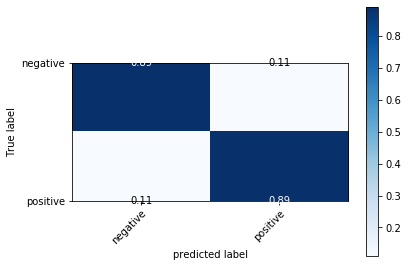

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, classes=['negative','positive'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### ROC Curve
* AUC = 0.8898

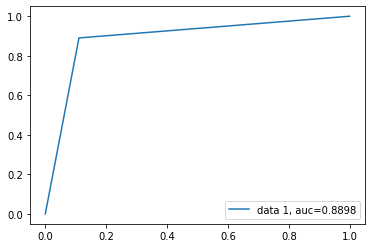

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

## 2.3. Decision Tree Classifier

* Limiting max depth of the decision tree can reduce overfitting and improve generalization

* the value of max_depth picked emperically

In [0]:
dtc = DTC(random_state=42, max_depth=9)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

### 2.3.1. Evaluation

In [0]:
# Predict and print metrics
y_pred_dtc = np.zeros((X_test.shape[0]),dtype=np.int8)
for i in range(X_test.shape[0]):
    y_pred_dtc[i] = dtc.predict([X_test[i]])

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_dtc, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
precisions.append(precision)

Presicion = 79.87653473214532 % Recall = 79.872 % f1 = 79.87123620198041 %


### Confusion Matrix

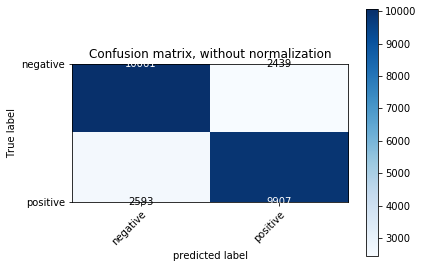

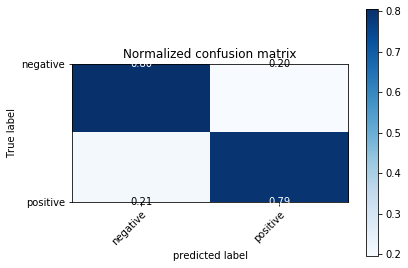

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=['negative','positive'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### ROC Curve
* AUC = 0.7872

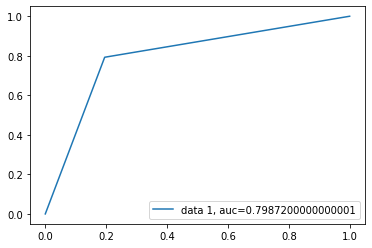

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_dtc)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

## 2.4 Random Forest classifier

In [0]:
rfc = RandomForestClassifier(n_estimators=24, random_state=42)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=24,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 2.4.1. Evaluation

In [0]:
# Predict and print metrics
y_pred_rfc = np.zeros((X_test.shape[0]),dtype=np.int8)
for i in range(X_test.shape[0]):
    y_pred_rfc[i] = rfc.predict([X_test[i]])

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_rfc, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
precisions.append(precision)

Presicion = 83.88948326416896 % Recall = 83.884 % f1 = 83.88334808787683 %


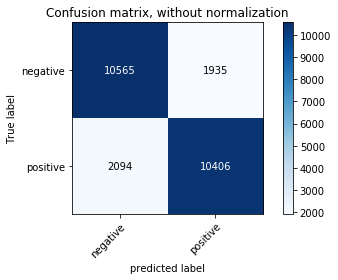

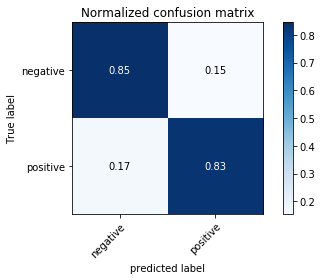

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rfc, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rfc, classes=['negative','positive'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

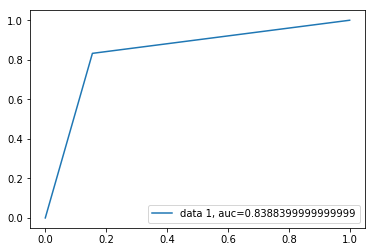

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_rfc)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

# 2.5. Comparision of classifiers  - Bert Sentences method

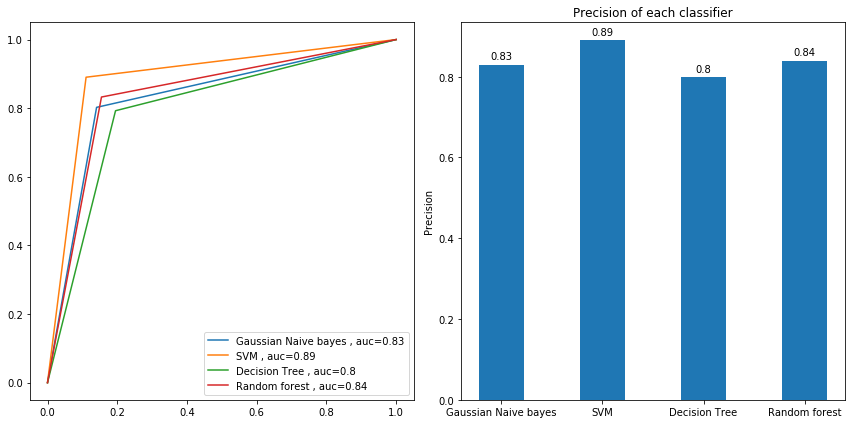

In [0]:
def autolabel(rects):
    """Attach a text label above each bar """
    for rect in rects:
        height = rect.get_height()
        ax[1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Compare ROC and AUC among different classifiers
y_preds = [y_pred, y_pred_svm, y_pred_dtc, y_pred_rfc]
clsf_names=['Gaussian Naive bayes','SVM','Decision Tree','Random forest']
#plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,6))
for i in range(len(y_preds)):

  fpr, tpr, _ = roc_curve(y_test, y_preds[i])
  roc_auc = auc(fpr, tpr)
  ax[0].plot(fpr,tpr,label=clsf_names[i]+" , auc="+str(round(roc_auc,2)))
  
ax[0].legend(loc=4)
 
labels = clsf_names
data = np.round(precisions,2)

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars


rects1 = ax[1].bar(x, data, width, label="Prec")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision of each classifier')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)

autolabel(rects1)

fig.tight_layout()

plt.show()

*  The best performance is for SVM
*  We can notice from ROC Curve that the overall performance of classifiers is better than BoW method which shows the ability of Bert embeddings.